> No artificial intelligence was used on this assignment. This was done 100% locally. 

1. Briefly explain the scenario in which you collected your data, whether you were in a vehicle or train, your approximate or exact start/stop locations. (6 Pts.)
      > This was done on train 1807 from South Station to Providence. Started to record at Back Bay with stops about every five minutes. My phone was on a table and any movement was due to the train and the train alone, except for one time where I picked it up right before Canton Junction. You could actually see where my stops are (the decrease then increase in y_acceleration), along with the time I picked my phone up.

    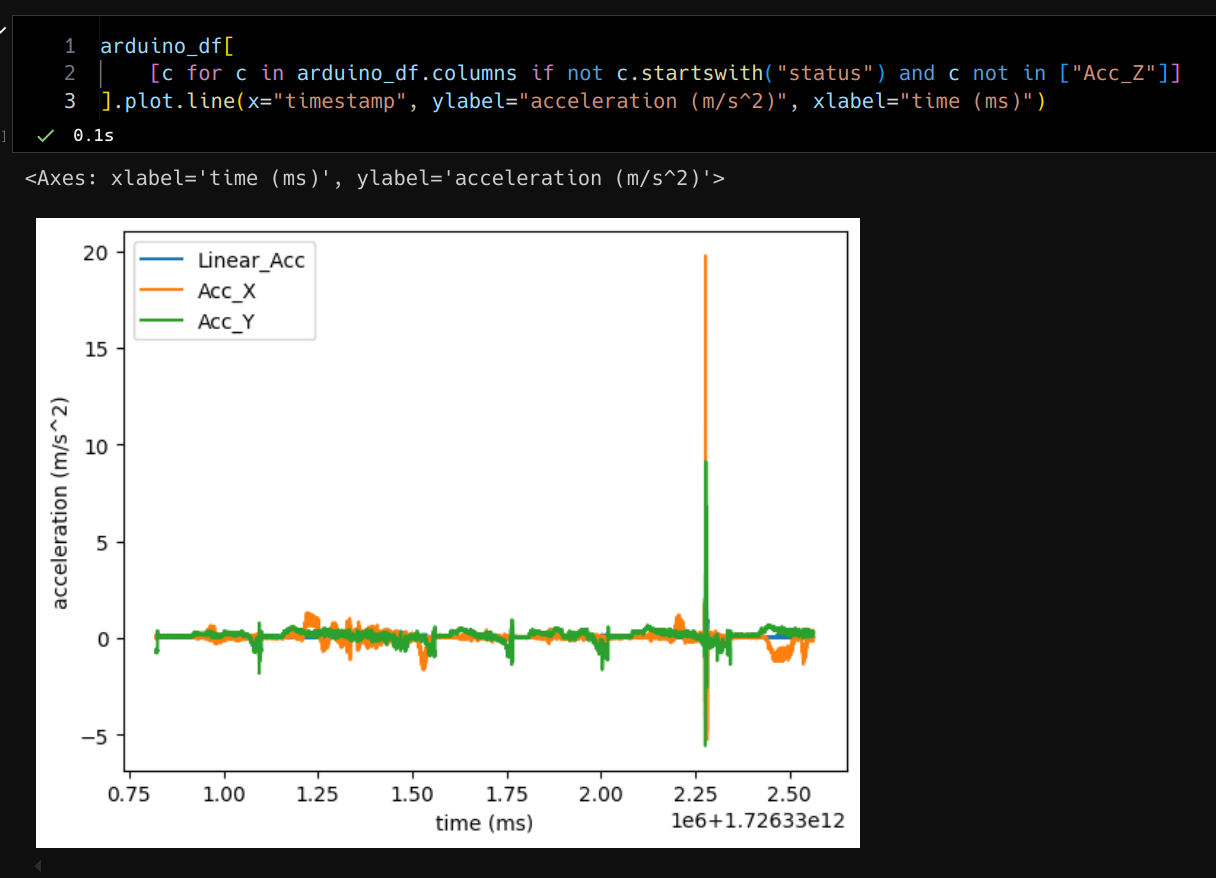

      
2. Did the app record equal number of data points in each second? Explain. (10 Pts.)

      > It does for the most part. I originally began to work on this assignment with a smaller dataset, but when moving to a larger dataset, it was a little weirder. In the code snippet below, if `.iloc[6:-7]` (which cuts off the first 6 and last 7 entries) is used, then you only get 15 readings per second. Otherwise you get `{7, 6, 15}`, indicating that the sensor was inconsistent. I don't know what causes this.

      > Typically, in industry, we don't get this luxury, because sensors are all different and may have anatomical differences; there was a point at Keolis (the MBTA commuter rail) where I experimented with trying to join together two datasets using timestamps and it just didn't work because the sensors were different. One of the sensors was a binary switch where a train's wheels would complete a circuit, while another one was where a train would pass over a transponder on the track. The speed of light, plus other anatomical differences made this pretty much impossible to do.
      
      ```python
          timestamps = arduino_df["timestamp"] // 1000
          print(
              {
                  len(timestamps[(timestamps >= unix_int) & (timestamps < unix_int + 1)])
                  for unix_int in timestamps.iloc[20:-20]
              }
          )  # prints {15}
      ```

3. Do the following in a Colab notebook on the saved .csv file and then copy/paste codes to the Word document:

In [1]:
# (A) Load the data

import os
import typing as t

# from statistics import LinearRegression
# import statistics as stat
import dmba

import pandas as pd
import numpy as np
import sklearn.model_selection as model_selection

# import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression

import utils

COLUMN_NAMES = {
    "timestamp": "timestamp",
    "LinearAccelerometerSensor": "Linear_Acc",
    "AccX": "Acc_X",
    "AccY": "Acc_Y",
    "AccZ": "Acc_Z",
}

# also sort the columns cause this is confusing, although it doesn't *really* matter
arduino_df: pd.DataFrame = pd.read_csv(
    os.path.join(os.curdir, "data", "arduino.csv"),
    dtype={col: (int if col.lower() == "timestamp" else float) for col in COLUMN_NAMES},
)[[s for s in COLUMN_NAMES]]

arduino_df.head()

,timestamp,LinearAccelerometerSensor,AccX,AccY,AccZ
0,1726330820701,0.054612,0.117206,-0.700843,9.689351
1,1726330820704,0.013653,0.117206,-0.700843,9.689351
2,1726330820770,0.011314,0.109123,-0.755928,9.702523
3,1726330820837,0.015450,0.072749,-0.696202,9.711205
4,1726330820903,0.016120,0.124092,-0.664019,9.728869


In [2]:
# (B) rename all columns to ...

arduino_df.drop(
    columns=[col for col in arduino_df.columns if col not in COLUMN_NAMES],
    inplace=True,
)
arduino_df.rename(columns=COLUMN_NAMES, inplace=True)

arduino_df.head()

,timestamp,Linear_Acc,Acc_X,Acc_Y,Acc_Z
0,1726330820701,0.054612,0.117206,-0.700843,9.689351
1,1726330820704,0.013653,0.117206,-0.700843,9.689351
2,1726330820770,0.011314,0.109123,-0.755928,9.702523
3,1726330820837,0.015450,0.072749,-0.696202,9.711205
4,1726330820903,0.016120,0.124092,-0.664019,9.728869


In [3]:
# (C) Show the code to display the summary statistics for column 2

arduino_df["Linear_Acc"].describe()

count    26127.000000
mean         0.037783
std          0.066756
min          0.000394
25%          0.010883
50%          0.023733
75%          0.048349
max          5.094513
Name: Linear_Acc, dtype: float64

##### (D) In less than a paragraph, what would be a real scenario where your current dataset would fall into "rare event oversampling"?

   > The one "rare" event within my dataset is that I accidently picked my phone up. This is the one time where the phone's motion wasn't due to the train. If I were to cut my dataset to 30 seconds around that point (and train a model around it), it would oversample that rare event.

In [4]:
""" 
(E) Create a new column, called "Status",
corresponding to column 2 where
linear accelerations of =< 0.2 is called stop
> 0.2 & =< 0.5 slow and > 0.5 fast
"""

arduino_df["status"] = arduino_df["Linear_Acc"].apply(
    lambda x: "stop" if x <= 0.2 else "slow" if x <= 0.5 else "fast"
)


# patch: mpatches.Rectangle
# ax = arduino_df["status"].value_counts().plot(kind="bar", ylabel="count")
# for patch in ax.patches:
#     ax.annotate(
#         str(patch.get_height()), (patch.get_x() * 1.005, patch.get_height() * 1.005)
#     )
arduino_df.head()

,timestamp,Linear_Acc,Acc_X,Acc_Y,Acc_Z,status
0,1726330820701,0.054612,0.117206,-0.700843,9.689351,stop
1,1726330820704,0.013653,0.117206,-0.700843,9.689351,stop
2,1726330820770,0.011314,0.109123,-0.755928,9.702523,stop
3,1726330820837,0.015450,0.072749,-0.696202,9.711205,stop
4,1726330820903,0.016120,0.124092,-0.664019,9.728869,stop


In [5]:
# (F) Convert this new column to a categorical variable
# ideally this would've been in the last part, where we cast inplace

arduino_df["status"] = arduino_df["status"].astype("category")

# this is for strong typing but it should refer to the same Object in memory
_cat_ref: pd.CategoricalDtype = arduino_df["status"].dtype
print(f"categories: {_cat_ref.categories.to_list()}")

categories: ['fast', 'slow', 'stop']


In [6]:
# G) Create binary dummies on this new column.

arduino_df = pd.get_dummies(
    arduino_df,
    prefix_sep="_",
    dummy_na=False,
    drop_first=True,  # this drops `"status_fast"`
    dtype=int,
    columns=["status"],
)  # no way to do this inplace :(

arduino_df.head()

,timestamp,Linear_Acc,Acc_X,Acc_Y,Acc_Z,status_slow,status_stop
0,1726330820701,0.054612,0.117206,-0.700843,9.689351,0,1
1,1726330820704,0.013653,0.117206,-0.700843,9.689351,0,1
2,1726330820770,0.011314,0.109123,-0.755928,9.702523,0,1
3,1726330820837,0.015450,0.072749,-0.696202,9.711205,0,1
4,1726330820903,0.016120,0.124092,-0.664019,9.728869,0,1


In [7]:
# H) Print the first 10 rows of data

# print(arduino_df.head(10)) # for normal python
arduino_df.head(10)  # for jupyter

,timestamp,Linear_Acc,Acc_X,Acc_Y,Acc_Z,status_slow,status_stop
0,1726330820701,0.054612,0.117206,-0.700843,9.689351,0,1
1,1726330820704,0.013653,0.117206,-0.700843,9.689351,0,1
2,1726330820770,0.011314,0.109123,-0.755928,9.702523,0,1
3,1726330820837,0.015450,0.072749,-0.696202,9.711205,0,1
4,1726330820903,0.016120,0.124092,-0.664019,9.728869,0,1
5,1726330820970,0.017072,0.045954,-0.669109,9.716145,0,1
6,1726330821037,0.015572,0.075892,-0.658331,9.671837,0,1
7,1726330821104,0.024716,0.114961,-0.687071,9.759854,0,1
8,1726330821170,0.011315,0.076940,-0.701741,9.765393,0,1
9,1726330821236,0.007971,0.070503,-0.689017,9.787547,0,1


In [8]:
# (I) Normalize the data

normalized_arduino_df = utils.normalize_df(
    arduino_df,
    *(
        col
        for col in arduino_df.columns
        if not col.startswith("status") and col != "timestamp"
    ),
)

normalized_arduino_df.head()

,timestamp,status_slow,status_stop,Linear_Acc,Acc_X,Acc_Y,Acc_Z
0,1726330820701,0,1,0.252103,0.278365,-2.400841,-0.293685
1,1726330820704,0,1,-0.361467,0.278365,-2.400841,-0.293685
2,1726330820770,0,1,-0.396508,0.253562,-2.562489,-0.236242
3,1726330820837,0,1,-0.334547,0.141952,-2.387224,-0.198382
4,1726330820903,0,1,-0.324521,0.299492,-2.292782,-0.121356


In [9]:
# (J) Partition the data to training (60%) and validation (40%)

outcome = "Linear_Acc"
predictors = [
    col for col in normalized_arduino_df.columns if col not in [outcome, "timestamp"]
]
df_list: list[pd.DataFrame | pd.Series] = model_selection.train_test_split(
    normalized_arduino_df[predictors],
    normalized_arduino_df[outcome],
    test_size=0.4,
    random_state=1,
)

train_x, valid_x, train_y, valid_y = df_list
# i may have overcomplicated this...
for i, __ in enumerate(df_list):
    _type = "training" if not i % 2 else "validation"
    if isinstance(__, pd.DataFrame):
        print(f"{_type} x: {__.__class__.__name__}{tuple(__.columns)}, len: {len(__)}")
        continue
    print(f"{_type} y: {__.__class__.__name__}('{outcome}'), len: {len(__)}")

training x: DataFrame('status_slow', 'status_stop', 'Acc_X', 'Acc_Y', 'Acc_Z'), len: 15676
validation x: DataFrame('status_slow', 'status_stop', 'Acc_X', 'Acc_Y', 'Acc_Z'), len: 10451
training y: Series('Linear_Acc'), len: 15676
validation y: Series('Linear_Acc'), len: 10451


In [10]:
# (K) fit the model and make predictions and show the first five rows

model = LinearRegression()
model.fit(train_x, train_y)

prediction = model.predict(train_x)

training_results = pd.DataFrame(
    {
        outcome: train_y,
        "predicted": prediction,
        "residual": train_y - prediction,
    }
)

training_results.head()

,Linear_Acc,predicted,residual
21908,1.871985,0.516229,1.355756
10757,-0.216965,-0.472012,0.255047
12864,-0.148903,-0.064727,-0.084176
6528,0.534657,0.000939,0.533717
3576,-0.253287,0.052133,-0.305420


In [11]:
# (L) Score the validation data

valid_prediction = model.predict(valid_x)
valid_results = pd.DataFrame(
    {
        outcome: valid_y,
        "predicted": valid_prediction,
        "residual": valid_y - valid_prediction,
    }
)
valid_results.head()

,Linear_Acc,predicted,residual
13818,-0.266686,0.035703,-0.302389
20734,0.627884,-0.147066,0.774949
23268,-0.473494,-0.040104,-0.433391
6987,-0.014346,0.263554,-0.277899
4894,-0.453336,-0.045093,-0.408243


In [12]:
# (M) Show the regression statistics for both training and validation

for name, df in {
    "training": training_results,
    "validation": valid_results,
}.items():
    print(f"\n{name}:")
    dmba.regressionSummary(df[outcome], df["predicted"])


training:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.6731
            Mean Absolute Error (MAE) : 0.4155
          Mean Percentage Error (MPE) : 75.3543
Mean Absolute Percentage Error (MAPE) : 316.6933

validation:

Regression statistics

                      Mean Error (ME) : 0.0048
       Root Mean Squared Error (RMSE) : 0.7447
            Mean Absolute Error (MAE) : 0.4226
          Mean Percentage Error (MPE) : 50.2913
Mean Absolute Percentage Error (MAPE) : 273.2705


##### (N) Out of the error metrics, pick two and interpret.


- `Mean Error (ME)`: The average of errors between predicted and actual values (from slides); since my values are wicked close to zero, it suggests that my predictions of linear acceleration given aren't consistently over/under estimated.

- ` Mean Absolute Error (MAE)`: The average magnitude of prediction errors. Unlike `RMSE`, `MAE` isn't very sensitive to outliers. I'd like to posit that since my `RMSE` and `MAE` are very close, I don't think there are many outliers in my data (I had like 35000 points I better not have). The low `MAE` indiciates that my preditor's performance was pretty good.